This notebook will be used to investigate the number of mergers/exposions that occur within each metallicity bin. We'll use Lieke's [notebook](https://github.com/LiekeVanSon/Proj_Melanie/blob/master/code/masterfolder/Test_fbinary_perM.ipynb) to calcuate the star forming mass per binary. 

In [1]:
# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

Let's get the WD+WD data

In [11]:
# reading in the HDF5 file
pathToweights_H5 = '/home/jovyan/CompasOutput/v03.08.01/N1e6_MassiveWDWD_NSNS_CEalpha1/MainRun/COMPAS_Output_wWeights.h5'  #path of the hdf5 file

Data_weights = h5.File(pathToweights_H5,"r")

# let's gather the system parameters group 
SP_WD_data = pd.DataFrame() # making a pandas dataframe

# from the double compact object group
keys_of_interest = ['Coalescence_Time', 'Eccentricity@DCO','Mass(1)',
       'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'SEED',
       'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time',
       'mixture_weight']

for key in keys_of_interest: #looping through the "keys" or paramters in BSE_System_Parameters

    SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

# Rates info directly taking out the 
merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]

Data_weights.close()

In [ ]:
# # reading in the HDF5 file
# # pathToweights_H5 = '/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha025/N1e6_MassiveWDWD_NSNS_CEalpha025_fbinNone.h5'  #path of the hdf5 file
# pathToweights_H5 = '/home/jovyan/CompasOutput/v03.08.01/N1e6_MassiveWDWD_NSNS_CEalpha1/MainRun/COMPAS_Output_wWeights.h5'  #path of the hdf5 file

# Data_weights = h5.File(pathToweights_H5,"r")

# # let's gather the system parameters group 
# SP_WD_data = pd.DataFrame() # making a pandas dataframe

# for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

#     SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

# # Rates info directly taking out the 
# merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
# rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
# rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
# DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
# redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
# # rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

# Data_weights.close()

In [10]:
SP_WD_data.keys()

Index(['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO',
       'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)',
       'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE',
       'Record_Type', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED',
       'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time',
       'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight'],
      dtype='object')

Let's just select for these systems in our dco table

In [ ]:
# let's try selecting all systems with white dwarfs now using the np.isin technique

# WDWD_mask = np.logical_and(np.isin(SP_WD_data['Stellar_Type(1)'],[10,11,12]),np.isin(SP_WD_data['Stellar_Type(2)'],[10,11,12]))
SP_DCO_DATA = SP_WD_data[DCO_mask]

# let's make sure that at least one of these white dwarfs are COWD
HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(SP_DCO_DATA)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))

SP_COWD_DATA = SP_DCO_DATA[carbon_oxygen_bool]

Let's bin the metallicities evenly in log so that when we eventually normalize it, the average star formaing mass needed is just a constant

In [16]:
# let's first make our bins that we want that are evenly spaced in log
metallicities = np.array(SP_COWD_DATA['Metallicity@ZAMS(1)'])
metallicities_log = np.log10(metallicities)
bins_Z = np.linspace(-4, np.log10(0.03), 20) # making sure we are considereing the bounds of COMPAS (so that np.digitze does not create extra bins)
bins_Z

# make bins slightly lower than min and slightly higher than min to get all of the systems (10^-4 for lower limit), log10(0.03) for upper limit

array([-4.        , -3.8696252 , -3.73925039, -3.60887559, -3.47850079,
       -3.34812599, -3.21775118, -3.08737638, -2.95700158, -2.82662677,
       -2.69625197, -2.56587717, -2.43550237, -2.30512756, -2.17475276,
       -2.04437796, -1.91400315, -1.78362835, -1.65325355, -1.52287875])

We now want to count how many systems are in each of these metallicity bins

In [13]:
# # using value_counts to count how many systems fit into each bin
# print(np.log10(merging_all_WD['Metallicity@ZAMS(1)']).value_counts(sort=False,bins=20))

In [17]:
counts_bins = pd.cut(np.log10(SP_COWD_DATA['Metallicity@ZAMS(1)']), bins=bins_Z).value_counts(sort=False)
counts_bins

Metallicity@ZAMS(1)
(-4.0, -3.87]       22631
(-3.87, -3.739]     23163
(-3.739, -3.609]    23685
(-3.609, -3.479]    23524
(-3.479, -3.348]    22843
(-3.348, -3.218]    23359
(-3.218, -3.087]    23413
(-3.087, -2.957]    23953
(-2.957, -2.827]    24623
(-2.827, -2.696]    24086
(-2.696, -2.566]    23700
(-2.566, -2.436]    24334
(-2.436, -2.305]    21386
(-2.305, -2.175]    20929
(-2.175, -2.044]    21653
(-2.044, -1.914]    21887
(-1.914, -1.784]    21356
(-1.784, -1.653]    21446
(-1.653, -1.523]    20915
Name: count, dtype: int64

In [21]:
# let's make sure all of our systems are being counted
counts_bins_array = np.array(counts_bins)
# counts_bins_reverse = list(reversed(counts_bins_array))
# counts_bins_reverse

print(np.shape(SP_COWD_DATA))
print(sum(counts_bins_array))

(432886, 12)
432886


Let's try a less efficent way. but one that makes more sense to me to count the number of systems in each bin

In [22]:
# let's make empty lists that help count how many of each system fit within each bin

bin_1 = []
bin_2 = []
bin_2 = []
bin_3 = []
bin_4 = []
bin_5 = []
bin_6 = []
bin_7 = []
bin_8 = []
bin_9 = []
bin_10 = []
bin_11 = []
bin_12 = []
bin_13 = []
bin_14 = []
bin_15 = []
bin_16 = []
bin_17 = []
bin_18 = []
bin_19 = []
bin_20 = []

# counting how many systems are within each bin by looping through our metallicities 
for systems in SP_COWD_DATA['Metallicity@ZAMS(1)']:
    if np.log10(systems) < bins_Z[0]:
        bin_1.append(1)
    if (np.log10(systems) > bins_Z[0]) and (np.log10(systems) < bins_Z[1]):
        bin_2.append(1)
    if (np.log10(systems) > bins_Z[1]) and (np.log10(systems) < bins_Z[2]):
        bin_3.append(1)
    if (np.log10(systems) > bins_Z[2]) and (np.log10(systems) < bins_Z[3]):
        bin_4.append(1)
    if (np.log10(systems) > bins_Z[3]) and (np.log10(systems) < bins_Z[4]):
        bin_5.append(1)
    if (np.log10(systems) > bins_Z[4]) and (np.log10(systems) < bins_Z[5]):
        bin_6.append(1)
    if (np.log10(systems) > bins_Z[5]) and (np.log10(systems) < bins_Z[6]):
        bin_7.append(1)
    if (np.log10(systems) > bins_Z[6]) and (np.log10(systems) < bins_Z[7]):
        bin_8.append(1)
    if (np.log10(systems) > bins_Z[7]) and (np.log10(systems) < bins_Z[8]):
        bin_9.append(1)
    if (np.log10(systems) > bins_Z[8]) and (np.log10(systems) < bins_Z[9]):
        bin_10.append(1)
    if (np.log10(systems) > bins_Z[9]) and (np.log10(systems) < bins_Z[10]):
        bin_11.append(1)
    if (np.log10(systems) > bins_Z[10]) and (np.log10(systems) < bins_Z[11]):
        bin_12.append(1)
    if (np.log10(systems) > bins_Z[11]) and (np.log10(systems) < bins_Z[12]):
        bin_13.append(1)
    if (np.log10(systems) > bins_Z[12]) and (np.log10(systems) < bins_Z[13]):
        bin_14.append(1)
    if (np.log10(systems) > bins_Z[13]) and (np.log10(systems) < bins_Z[14]):
        bin_15.append(1)
    if (np.log10(systems) > bins_Z[14]) and (np.log10(systems) < bins_Z[15]):
        bin_16.append(1)          
    if (np.log10(systems) > bins_Z[15]) and (np.log10(systems) < bins_Z[16]):
        bin_17.append(1)
    if (np.log10(systems) > bins_Z[16]) and (np.log10(systems) < bins_Z[17]):
        bin_18.append(1)
    if (np.log10(systems) > bins_Z[17]) and (np.log10(systems) < bins_Z[18]):
        bin_19.append(1)
    if (np.log10(systems) > bins_Z[18]):
        bin_20.append(1)

In [23]:
# let's make a new list that specifies how many systems are in each bin
counts_bin = [len(bin_1),len(bin_2),len(bin_3),len(bin_4),len(bin_5),len(bin_6),len(bin_7),len(bin_8),len(bin_9),len(bin_10),len(bin_11),\
              len(bin_12),len(bin_13),len(bin_14),len(bin_15),len(bin_16),len(bin_17),len(bin_18),len(bin_19),len(bin_20)]
counts_bin

[0,
 22631,
 23163,
 23685,
 23524,
 22843,
 23359,
 23413,
 23953,
 24623,
 24086,
 23700,
 24334,
 21386,
 20929,
 21653,
 21887,
 21356,
 21446,
 20915]

Both methods match up! I just added an extra empty bin at the start

In [15]:
bins_Z

array([-4.        , -3.8696252 , -3.73925039, -3.60887559, -3.47850079,
       -3.34812599, -3.21775118, -3.08737638, -2.95700158, -2.82662677,
       -2.69625197, -2.56587717, -2.43550237, -2.30512756, -2.17475276,
       -2.04437796, -1.91400315, -1.78362835, -1.65325355, -1.52287875])

Text(0, 0.5, 'Number of WD+WD Systems')

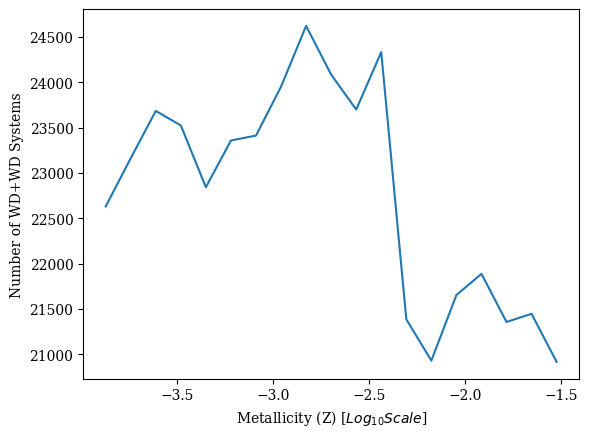

In [24]:
# let's plot our counts vs metallicities!

plt.plot(bins_Z[1:20], counts_bin[1:20])
plt.xlabel(r"Metallicity (Z) [$Log_{10} Scale$]")
plt.ylabel(r"Number of WD+WD Systems")

Let's now do a similar tast but count how many mergers there are per metallicity bin

In [35]:
# let's use the "Merges_Hubble_Time" flag to flag when binaries merge and produce graviational waves

merges_comaps = SP_COWD_DATA['Merges_Hubble_Time']==1

counts_bins_mergers = pd.cut(np.log10(SP_COWD_DATA['Metallicity@ZAMS(1)'][merges_comaps]), bins=bins_Z).value_counts(sort=False)
counts_bins_mergers


Metallicity@ZAMS(1)
(-4.0, -3.87]       22631
(-3.87, -3.739]     23163
(-3.739, -3.609]    23685
(-3.609, -3.479]    23524
(-3.479, -3.348]    22843
(-3.348, -3.218]    23359
(-3.218, -3.087]    23413
(-3.087, -2.957]    23953
(-2.957, -2.827]    24623
(-2.827, -2.696]    24086
(-2.696, -2.566]    23700
(-2.566, -2.436]    24334
(-2.436, -2.305]    21386
(-2.305, -2.175]    20929
(-2.175, -2.044]    21653
(-2.044, -1.914]    21887
(-1.914, -1.784]    21356
(-1.784, -1.653]    21446
(-1.653, -1.523]    20915
Name: count, dtype: int64

In [48]:
bins_Z

array([-4.        , -3.8696252 , -3.73925039, -3.60887559, -3.47850079,
       -3.34812599, -3.21775118, -3.08737638, -2.95700158, -2.82662677,
       -2.69625197, -2.56587717, -2.43550237, -2.30512756, -2.17475276,
       -2.04437796, -1.91400315, -1.78362835, -1.65325355, -1.52287875])

Text(0, 0.5, 'Number of WD+WD Systems')

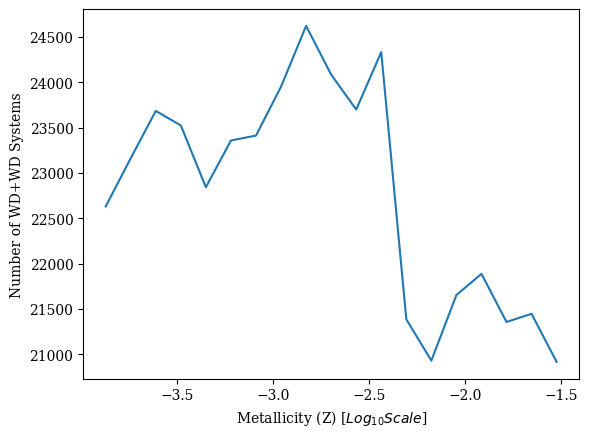

In [ ]:
# let's plot our counts vs metallicities!
# there are only 19 ranges, so we group the lowest metallicity bin with the next range (start after -4 in our bin)

plt.plot(bins_Z[1:20], counts_bins_mergers)
plt.xlabel(r"Metallicity (Z) [$Log_{10} Scale$]")
plt.ylabel(r"Number of WD+WD Systems")

Let's do the same thing but normalize our counts with the amount of star forming mass needed to make the binaries at a each redshift using Lieke's method

In [50]:
###################################################
# New version of analytical calculation
###################################################
def analytical_star_forming_mass_per_binary_using_kroupa_imf(
        m1_min, m1_max, m2_min, fbin=1., imf_mass_bounds=[0.01,0.08,0.5,200]
):
    """
    Analytical computation of the mass of stars formed per binary star formed within the
    [m1 min, m1 max] and [m2 min, ..] rage,
    using the Kroupa IMF:

        p(M) \propto M^-0.3 for M between m1 and m2
        p(M) \propto M^-1.3 for M between m2 and m3;
        p(M) = alpha * M^-2.3 for M between m3 and m4;

    m1_min, m1_max are the min and max sampled primary masses
    m2_min is the min sampled secondary mass

    This function further assumes a flat mass ratio distribution with qmin = m2_min/m1, and  m2_max = m1_max
    Lieke base on Ilya Mandel's derivation
    """
    # Kroupa IMF 
    m1, m2, m3, m4 = imf_mass_bounds
    continuity_constants = [1./(m2*m3), 1./(m3), 1.0]  
    IMF_powers = [-0.3, -1.3, -2.3]  

    if m1_min < m3:
        raise ValueError(f"This analytical derivation requires IMF break m3  < m1_min ({m3} !< {m1_min})")
    if m1_min > m1_max:
        raise ValueError(f"Minimum sampled primary mass cannot be above maximum sampled primary mass: m1_min ({m1_min} !<  m1_max {m1_max})")
    if m1_max > m4:
        raise ValueError(f"Maximum sampled primary mass cannot be above maximum mass of Kroupa IMF:  m1_max ({m1_max} !<  m4 {m4})")
    
    # normalize IMF over the complete mass range:
    alpha = (-(m4**(-1.3)-m3**(-1.3))/1.3 - (m3**(-0.3)-m2**(-0.3))/(m3*0.3) + (m2**0.7-m1**0.7)/(m2*m3*0.7))**(-1)
    # print('alpha', alpha)

    # we want to compute M_stellar_sys_in_universe / N_binaries_in_COMPAS
    #  = N_binaries_in_universe/N_binaries_in_COMPAS * N_stellar_sys_in_universe/N_binaries_in_universe * M_stellar_sys_in_universe/N_stellar_sys_in_universe
    #  = 1/fint * 1/fbin * average mass of a stellar system in the Universe

    # fint =  N_binaries_in_COMPAS/N_binaries_in_universe: fraction of binaries that COMPAS simulates
    fint = -alpha / 1.3 * (m1_max ** (-1.3) - m1_min ** (-1.3)) + alpha * m2_min / 2.3 * (m1_max**(-2.3) - m1_min **(-2.3))


    # Next for N_stellar_sys_in_universe/N_binaries_in_universe * M_stellar_sys_in_universe/N_stellar_sys_in_universe
    # N_stellar_sys_in_universe/N_binaries_in_universe = the binary fraction 
    # fbin edges and values are chosen to approximately follow Figure 1 from Offner et al. (2023)
    binary_bin_edges = [m1, 0.08, 0.5, 1, 10, m4]    
    if isinstance(fbin, (int, float)):
        # Constant binary fraction
        binaryFractions = [fbin] * 5
    else:
        # Variable binary fraction with mass
        binaryFractions = [0.1, 0.225, 0.5, 0.8, 1.0] 


    # M_stellar_sys_in_universe/N_stellar_sys_in_universe = average mass of a stellar system in the Universe,
    # we are computing 1/fbin * M_stellar_sys_in_universe/N_stellar_sys_in_universe, skipping steps this leads to:
    # int_A^B (1/fb(m1) + 0.5) m1 P(m1) dm1. 
    # This is a double piecewise integral, i.e. pieces over the binary fraction bins and IMF mass bins.
    piece_wise_integral = 0

    # For every binary fraction bin
    for i in range(len(binary_bin_edges) - 1):
        fbin = binaryFractions[i] # Binary fraction for this range

        # And every piece of the Kroupa IMF
        for j in range(len(imf_mass_bounds) - 1):
            exponent = IMF_powers[j] # IMF exponent for these masses

            # Check if the binary fraction bin overlaps with the IMF mass bin
            if binary_bin_edges[i + 1] <= imf_mass_bounds[j] or binary_bin_edges[i] >= imf_mass_bounds[j + 1]:
                continue  # No overlap

            # Integrate from the most narrow range
            m_start = max(binary_bin_edges[i], imf_mass_bounds[j])
            m_end = min(binary_bin_edges[i + 1], imf_mass_bounds[j + 1])
            print("Integrating from", m_start, "to", m_end, "for fbin =", fbin, "and exponent =", exponent)

            # Compute the definite integral:
            integral = ( m_end**(exponent + 2) - m_start**(exponent + 2) ) / (exponent + 2) * continuity_constants[j]

            # Compute the sum term
            sum_term = (1 /fbin + 0.5) * integral
            piece_wise_integral += sum_term

    # combining them:
    Average_mass_stellar_sys_per_fbin = alpha * piece_wise_integral

    # Now compute the average mass per binary in COMPAS M_stellar_sys_in_universe / N_binaries_in_COMPAS
    M_sf_Univ_per_N_binary_COMPAS = (1/fint) * Average_mass_stellar_sys_per_fbin

    return M_sf_Univ_per_N_binary_COMPAS

In [51]:
m1min = 10
m1max = 150
m2min= 0.1

analytical_star_forming_mass_per_binary = analytical_star_forming_mass_per_binary_using_kroupa_imf(m1min, m1max, m2min)

Integrating from 0.01 to 0.08 for fbin = 1.0 and exponent = -0.3
Integrating from 0.08 to 0.5 for fbin = 1.0 and exponent = -1.3
Integrating from 0.5 to 1 for fbin = 1.0 and exponent = -2.3
Integrating from 1 to 10 for fbin = 1.0 and exponent = -2.3
Integrating from 10 to 200 for fbin = 1.0 and exponent = -2.3


In [53]:
analytical_star_forming_mass_per_binary

197.1969961608149

Text(0, 0.5, 'Number of WD+WD Systems')

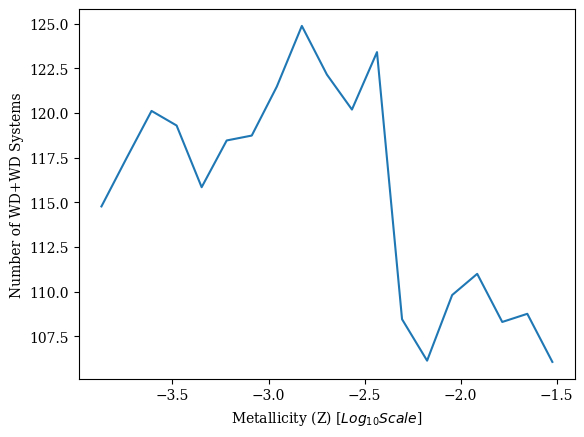

In [54]:
# let's plot our normalized counts vs metallicities!
# there are only 19 ranges, so we group the lowest metallicity bin with the next range (start after -4 in our bin)

plt.plot(bins_Z[1:20], counts_bins_mergers/analytical_star_forming_mass_per_binary)
plt.xlabel(r"Metallicity (Z) [$Log_{10} Scale$]")
plt.ylabel(r"Number of WD+WD Systems")

In [17]:
### These functions are from Lieke's Yield code on her github

def totalMassEvolvedPerZ(pathCOMPASh5, x2=0.08, x3=0.5, a1=-0.3, a2=-1.3, a3=-2.3, C1=1.,
                         binaryFraction=0.7, Mmin_universe=0.05, Mmax_universe=300., sampleSize=2000000,
                         metallicity_bins = np.logspace(-4,np.log10(0.03), 10) ):
    """_summary_

    Args:
        # COMPAS simulation parameters
        pathCOMPASh5 (_type_, optional): path to your COMPAS file. Defaults to None.

        # Broken powerlaw (Kroupa IMF) parameters
        x1, x2, x3, x4: float, the break points (mass ranges) for the three segments
        a1, a2, a3: float, the power law indices 
        <0.01 - 0.08> a = -0.3, <0.08 - 0.5> a = -1.3, <0.5 - 200> a = -2.3
        C1: float, the normalization constant for the first segment
        
        # Believes about star formation in the Universe
        binaryFraction (int, optional): What fraction of stars are in binaries. Default= 1.
        Mmin_universe, Mmax_universe (float): the min and max mass that stars in the Universe can be born with  Defaults: 0.01 and 200.

    Returns:
        _type_: _description_
    """ 
    x1 = Mmin_universe
    x4 = Mmax_universe

    # Open the COMPAS file
    COMPASdataf = h5.File(pathCOMPASh5, 'r')

    # Min and max M sampled in your COMPAS simulation.
    COMPAS_m1       = COMPASdataf['BSE_System_Parameters']['Mass@ZAMS(1)'][()]
    Mlower_COMPAS   = np.min(COMPAS_m1)
    Mupper_COMPAS   = np.max(COMPAS_m1)


    ##########################
    # Create Sample Universe 
    ##########################
    # we will use 'inverse transform sampling method' to sample our sample Universe from the IMF

    ### Primary mass
    # first we compute the y-values of the CDF of our IMF at Mmin_universe and Mmax_universe
    # Mmin_universe and Mmax_universe have to be between x1 and x4
    CDFmin = CDFbrokenPowerLaw(np.array([Mmin_universe]), x1, x2, x3, x4, a1, a2, a3, C1)
    CDFmax = CDFbrokenPowerLaw(np.array([Mmax_universe]), x1, x2, x3, x4, a1, a2, a3, C1)

    # Now we can sample Uniformly from the CDF between CDFmin and CDFmax
    drawM1      = np.random.uniform(CDFmin,CDFmax,sampleSize)
    # Convert CDF values back to masses
    M1          = invertCDFbrokenPowerLaw(drawM1, x1, x2, x3, x4, a1, a2, a3, C1)

    ### Binary fraction
    # we want that binaryFraction of the stars are in binaries
    # Hence by drawing between 0-1, we have to throw out everything that is above binaryFraction (i.e. = single and m2 = 0)
    # ! NOTE that this assumes that the binary Fraction is mass indepent! > Future work to implenet Max Moe ps and qs options
    drawBinary      = np.random.uniform(0,1,sampleSize)
    maskBinary      = drawBinary < binaryFraction  #booleans

    ### Secondary mass
    # mass ratio (q = m2/m1) distribution is assumed to be flat 
    # so then the drawM2 (if it is in a binary) just becomes the mass fraction.
    drawM2          = np.random.uniform(0,1,sampleSize)    # we are actually sampling q
    M2              = np.zeros(sampleSize)                 #
    M2[maskBinary]  = drawM2[maskBinary] * M1[maskBinary]  # = q * m1, all the ones outside the mask remain zero
    
    totalMassInStarFormation = np.sum(M1) + np.sum(M2)


    ##########################
    # Select what lies in the range of COMPAS
    ##########################
    # mask M1 and M2 to see what lies in the range of COMPAS
    maskM1          = (M1>=Mlower_COMPAS) & (M1<=Mupper_COMPAS)
    maskBinaries    = (M2!=0)
    mask_COMPAS     = maskM1 & maskBinaries

    totalMassEvolvedCOMPAS = np.sum(M1[mask_COMPAS]) + np.sum(M2[mask_COMPAS])

    ##########################
    # fraction of total universe that was sampled by COMPAS
    fraction_sampled = totalMassEvolvedCOMPAS/float(totalMassInStarFormation)

    # average mass of a binary in COMPAS simulation  
    AverageMassPerBinaryCOMPAS  = totalMassEvolvedCOMPAS / sum(mask_COMPAS)         

    ##########################
    # Finally compute the tot mass evolved per Z
    ##########################
    # load a bit more COMPAS data
    COMPAS_m2       = COMPASdataf['BSE_System_Parameters']['Mass@ZAMS(2)'][()]
    COMPAS_metals   = COMPASdataf['BSE_System_Parameters']['Metallicity@ZAMS(1)'][()]
    uniqueZ_COMPAS, countsZ_COMPAS = np.unique(COMPAS_metals, return_counts=True) #   uniqueZ_COMPAS  = np.unique(COMPAS_metals)
    
    # Determine if your samples are weighted
    boolWeighted = 'mixture_weight' in COMPASdataf['BSE_System_Parameters'].keys()

    # samples are weighted we can't just add M1 + M2 from simulation 
    if boolWeighted: 
        print('Weighted samples')        
        # I assume that if you have more than 100 metallicities, it's not discrete, but a continuous Z distribution
        if len(uniqueZ_COMPAS) > 100: 
            print('using continuous metallicities !! Assumed to be sampled flat-in-log !!')
            bin_indices          = np.digitize(COMPAS_metals, metallicity_bins, right=True) # Bin your metallicities
            # np.digitize - chekcs which metallicity bin a specific compas metals should fall in (with say which numbered bin the system should be in)
            #NbinariesEvolvedPerZ = np.bincount(bin_indices)#, minlength=len(metallicity_bins) + 1) # Count the number of elements in each bin (counts how often each bin index occurs)
            # bincount not working - giving a zero mass for the first mass evolved per z
            _, NbinariesEvolvedPerZ = np.unique(bin_indices,return_counts=True)


        else: 
            print('using discrete metallicities')
            NbinariesEvolvedPerZ    = countsZ_COMPAS

        totalMassEvolvedPerMetallicity  = AverageMassPerBinaryCOMPAS * NbinariesEvolvedPerZ    
       
    # Unweighted samples 
    else: 
        print('UN-weighted samples')
        total = []
        if len(uniqueZ_COMPAS) > 100: 
            print('using continuous metallicities !! Assumed to be sampled flat-in-log !!')
            # loop over each metallicity_bin
            for Z_i in range(len(metallicity_bins) - 1):
                z_bin_mask = (COMPAS_metals >= metallicity_bins[Z_i] ) & (COMPAS_metals < metallicity_bins[Z_i+1])
                total.append( np.sum(COMPAS_m1[z_bin_mask]) + np.sum(COMPAS_m2[z_bin_mask]) )
                
        else: # Simulation with discrete metallicities
            print('using discrete metallicities')
            for Z in uniqueZ_COMPAS:
                Zmask = COMPAS_metals == Z
                total.append( np.sum(COMPAS_m1[Zmask]) + np.sum(COMPAS_m2[Zmask]) )
                
        MassEvolvedPerZ  = np.array(total)  
    
        # We need to muliply the mass evolved per metallicity times (1/fraction) to know the total mass evolved per metallicity
        totalMassEvolvedPerMetallicity = (MassEvolvedPerZ)/(fraction_sampled)

    return totalMassEvolvedPerMetallicity

def CDFbrokenPowerLaw(x, x1=0.01, x2=0.08, x3=0.5, x4=200, a1=-0.3, a2=-1.3, a3=-2.3, C1=1):
    """
    CDF values of a three-part broken powerlaw representing a Kroupa IMF by default.
    
    Parameters:
    x: array-like, the input values
    x1, x2, x3, x4: float, the break points (mass ranges) for the three segments
    a1, a2, a3: float, the power law indices 
    C1: float, the normalization constant for the first segment
    
    Returns:
    yvalues: array-like, the output values of the CDF
    """
    
    # Initialize the output array
    yvalues = np.zeros(len(x))
    
    # Calculate the normalization constants for the other segments
    # Ensuring that the next segments start where the previous segment ends
    C2 = float(C1 * (x2**(a1-a2)))
    C3 = float(C2 * (x3**(a2-a3)))
    
    # Calculate the normalization factors for the three segments
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    # Calculate the denominator of the CDF
    bottom = N1+N2+N3
    
    # Calculate the CDF values for x range: x1<=x<x2
    mask1 = (x>=x1) & (x<x2)
    top1 = ( (1./(a1+1) ) * C1 * (x[mask1]**(a1+1) ) - (1./(a1+1) ) * C1 * (x1**(a1+1) ) ) 
    yvalues[mask1] = top1/bottom
    
    # Calculate the CDF values for x range: x2<=x<x3
    mask2 = (x>=x2) & (x<x3)
    top2 =  N1 + ( (1./(a2+1) ) * C2 * (x[mask2]**(a2+1) ) - (1./(a2+1)) * C2 * (x2**(a2+1) ) ) 
    yvalues[mask2] = top2/bottom
    
    # Calculate the CDF values for x range: x3<=x<=x4
    mask3 = (x>=x3) & (x<=x4)
    top3 =  N1 + N2 + ( (1./(a3+1)) * C3 * (x[mask3]**(a3+1)) - (1./(a3+1)) * C3 * (x3**(a3+1) ) )
    yvalues[mask3] = top3/bottom
    
    return yvalues


def invertCDFbrokenPowerLaw(CDF, x1, x2, x3, x4, a1, a2, a3, C1):
    """
    Invert y-values of a CDF back to x-vals (i.e. the masses)
    Specifically for a three-part piece-wise powerlaw representing a Kroupa IMF by default. 

    Parameters:
    CDF: array-like, the CDF values to invert
    x1, x2, x3, x4: float, the break points (ranges) for the three segments
    a1, a2, a3: float, the power law indices for the three segments
    C1: float, the normalization constant for the first segment

    Returns:
    xvalues: array-like, the inverted CDF values
    """
    
    # Calculate the normalization constants for the second and third segments
    C2 = float(C1 * (x2**(a1-a2)))
    C3 = float(C2 * (x3**(a2-a3)))
    
    # Calculate the area under the curve for each segment
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    # Calculate the CDF values at the breakpoints
    CDFx2 = CDFbrokenPowerLaw(np.array([x2,x2]), x1, x2, x3, x4, a1, a2, a3, C1)[0]
    CDFx3 = CDFbrokenPowerLaw(np.array([x3,x3]), x1, x2, x3, x4, a1, a2, a3, C1)[0]

    # Initialize the output array
    xvalues = np.zeros(len(CDF))
    
    # Calculate the inverse CDF values for the first segment
    mask1 = (CDF < CDFx2)
    xvalues[mask1] =  (((CDF[mask1]*(N1+N2+N3))  + \
                      ( (1./(a1+1))*C1*(x1**(a1+1))))/((1./(a1+1))*C1))**(1./(a1+1))
    
    # Calculate the inverse CDF values for the second segment
    mask2 = (CDFx2<= CDF) & (CDF < CDFx3)
    xvalues[mask2] = ((((CDF[mask2]*(N1+N2+N3))-(N1))  + \
                      ( (1./(a2+1))*C2*(x2**(a2+1))))/((1./(a2+1))*C2))**(1./(a2+1))
    
    # Calculate the inverse CDF values for the third segment
    mask3 = (CDFx3<= CDF) 
    xvalues[mask3] = ((((CDF[mask3]*(N1+N2+N3))-(N1+N2))  + \
                      ((1./(a3+1))*C3*(x3**(a3+1))))/((1./(a3+1))*C3))**(1./(a3+1))
    
    # Return the inverse CDF values
    return xvalues

In [10]:
# Get the total mass evolved per Z
# think about hoe bonary fraction changes for different mass bins (Offner, Moe 2022) - figure 1
# i don't think m_min and m_max are of the simulation - thye ar eof the universe so keep these values
totalMassEvolvedPerMetallicity_WD = totalMassEvolvedPerZ(pathToweights_H5,
                         binaryFraction=0.7, Mmin_universe=0.05, Mmax_universe=300.,
                         metallicity_bins = 10**(bins_Z))
print('Total mass evolved per Z for WD+WD:', totalMassEvolvedPerMetallicity_WD)

Weighted samples
using continuous metallicities !! Assumed to be sampled flat-in-log !!
Total mass evolved per Z for WD+WD: [247425.44280774 246276.61703987 245606.85626832 244797.56200269
 246127.78131286 244220.82356052 244239.42802639 244346.40370518
 244960.35107911 244239.42802639 243932.45433943 244299.89254049
 245802.20316002 244411.51933575 242848.74420213 243830.12977711
 244504.54166513 244760.35307094 244485.93719926]


In [11]:
center_bin_z = (bins_Z[1:]+bins_Z[:-1])/2

In [12]:
print("Length of center metallicity bins list", len(center_bin_z))
print("Length of the total mass evlolved per metallicity list", len(totalMassEvolvedPerMetallicity_WD))

Length of center metallicity bins list 19
Length of the total mass evlolved per metallicity list 19


It seems like the first mass evolved per metallicity is zero and represents the stars appearing in our simulation? We need no mass to envolve the inital mass? The length of this list is one more than the bins so we just need everything in total mass evolve per Z except for the first element

We now need to find the amount of systems that fall into each bin and then weight this count with the weights column 

In [13]:
bin_indices_WD = np.digitize(np.log10(SP_COWD_DATA['Metallicity@ZAMS(1)']), bins_Z) # Bin your metallicities, make sure both bins in log space
# np.digitize - checks which metallicity bin a specific compas metals should fall in (with say which numbered bin the system should be in)
# return an array of numbers that represent the bins (the 1st metallicity is in bin 5...)
print(bin_indices_WD)
print(len(np.unique(bin_indices_WD)))

[19  3 11 ... 10 13  5]
19


In [14]:
# we now want to find the actual number of systems that should fall into each bin by considering the weights fo each system
weighted_counts_WD = [] # let's make an empty list to add to later

# we can loop through our first to 20th metallicity bin
for bin in np.unique(bin_indices_WD):
    metals_bool = np.where(bin_indices_WD==bin)[0] # we want to see where in our array a system falls within to a certain bin
    # for example we want to see where in bin_indicies the systems fall into the first metallicity bin 
    weighted_counts_WD.append(sum(SP_COWD_DATA['mixture_weight'].iloc[metals_bool])) # we then select only the weights pertaining to a certian metallicity bin and sum them up

In [15]:
len(weighted_counts_WD)

19

Let's now compute the formation efficency by divinding these weighted counts and the mass evolved to form these systems for each metallicity

In [16]:
# divide the weighted sums with the total mass evolved oer metallicity
formation_efficency = weighted_counts_WD/totalMassEvolvedPerMetallicity_WD
# N_wdwd/M_evolv
# number of systems formed / mass evolved for these systems to be made (take the nondiscrete and weighted samples metallicity)

In [17]:
formation_efficency

array([0.00625875, 0.00655598, 0.00620382, 0.00616715, 0.00598699,
       0.0056512 , 0.00569172, 0.00590793, 0.00556177, 0.00494135,
       0.00481771, 0.00525653, 0.00425342, 0.00420484, 0.00412985,
       0.00490066, 0.00507263, 0.00521719, 0.00517179])

Let's use this formation efficency to get the overall trend of the metallicity distirbution

Text(0, 0.5, 'Number of WD+WD Systems')

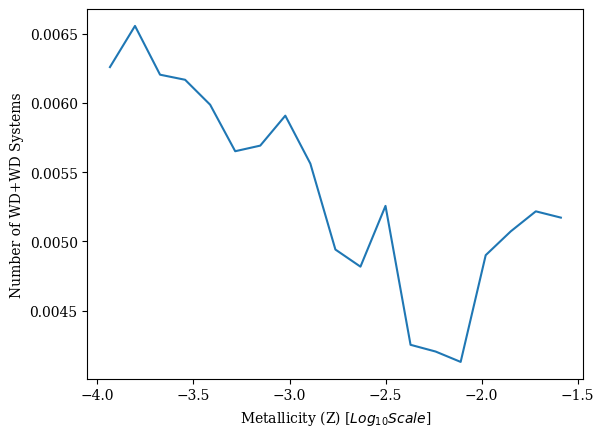

In [18]:
# let's plot our counts vs metallicities!

plt.plot(center_bin_z, formation_efficency)
plt.xlabel(r"Metallicity (Z) [$Log_{10} Scale$]")
plt.ylabel(r"Number of WD+WD Systems")

We now want to find the metallicity yield for the specific mass regimes we care about

In [19]:
# let's add the flags for specific calssifications of SN Ia

SN_Ia_HVS,two_star_SNIA,Champagne_Supernova = useful_fncs.check_if_SNIA(SP_COWD_DATA['Mass(1)'],SP_COWD_DATA['Mass(2)'])
# adding the flags to the dataframe
SP_COWD_DATA = SP_COWD_DATA.assign(SN_Ia_HVS = SN_Ia_HVS)
SP_COWD_DATA = SP_COWD_DATA.assign(two_star_SNIA = two_star_SNIA)
SP_COWD_DATA = SP_COWD_DATA.assign(Champagne_Supernova = Champagne_Supernova)

In [25]:
### formation efficeny for SN Ia HVS

bin_indices_WD_SN_Ia_HVS = np.digitize(np.log10(SP_COWD_DATA['Metallicity@ZAMS(1)'][SP_COWD_DATA['SN_Ia_HVS']==True]), bins_Z) # Bin your metallicities, make sure both bins in log space
# np.digitize - checks which metallicity bin a specific compas metals should fall in (with say which numbered bin the system should be in)
# return an array of numbers that represent the bins (the 1st metallicity is in bin 5...)

# we now want to find the actual number of systems that should fall into each bin by considering the weights fo each system
weighted_counts_WD_SN_Ia_HVS = [] # let's make an empty list to add to later

# we can loop through our first to 20th metallicity bin
for bin in np.unique(bin_indices_WD_SN_Ia_HVS):
    metals_bool = np.where(bin_indices_WD_SN_Ia_HVS==bin)[0] # we want to see where in our array a system falls within to a certain bin
    # for example we want to see where in bin_indicies the systems fall into the first metallicity bin 
    weighted_counts_WD_SN_Ia_HVS.append(sum(SP_COWD_DATA['mixture_weight'][SP_COWD_DATA['SN_Ia_HVS']==True].iloc[metals_bool])) # we then select only the weights pertaining to a certian metallicity bin and sum them up

formation_efficency_SN_Ia_HVS = weighted_counts_WD_SN_Ia_HVS/totalMassEvolvedPerMetallicity_WD
# N_wdwd/M_evolv
# number of systems formed / mass evolved for these systems to be made (take the nondiscrete and weighted samples metallicity)

In [30]:
### formation efficeny for SN Ia HVS

bin_indices_WD_two_star_SNIA = np.digitize(np.log10(SP_COWD_DATA['Metallicity@ZAMS(1)'][SP_COWD_DATA['two_star_SNIA']==True]), bins_Z) # Bin your metallicities, make sure both bins in log space
# np.digitize - checks which metallicity bin a specific compas metals should fall in (with say which numbered bin the system should be in)
# return an array of numbers that represent the bins (the 1st metallicity is in bin 5...)

# we now want to find the actual number of systems that should fall into each bin by considering the weights fo each system
weighted_counts_WD_two_star_SNIA = [] # let's make an empty list to add to later

# we can loop through our first to 20th metallicity bin
for bin in np.unique(bin_indices_WD_two_star_SNIA):
    metals_bool = np.where(bin_indices_WD_two_star_SNIA==bin)[0] # we want to see where in our array a system falls within to a certain bin
    # for example we want to see where in bin_indicies the systems fall into the first metallicity bin 
    weighted_counts_WD_two_star_SNIA.append(sum(SP_COWD_DATA['mixture_weight'][SP_COWD_DATA['two_star_SNIA']==True].iloc[metals_bool])) # we then select only the weights pertaining to a certian metallicity bin and sum them up

formation_efficency_two_star_SNIA = weighted_counts_WD_two_star_SNIA/totalMassEvolvedPerMetallicity_WD
# N_wdwd/M_evolv
# number of systems formed / mass evolved for these systems to be made (take the nondiscrete and weighted samples metallicity)

In [33]:
### formation efficeny for SN Ia HVS

bin_indices_WD_Champagne_Supernova = np.digitize(np.log10(SP_COWD_DATA['Metallicity@ZAMS(1)'][SP_COWD_DATA['Champagne_Supernova']==True]), bins_Z) # Bin your metallicities, make sure both bins in log space
# np.digitize - checks which metallicity bin a specific compas metals should fall in (with say which numbered bin the system should be in)
# return an array of numbers that represent the bins (the 1st metallicity is in bin 5...)

# we now want to find the actual number of systems that should fall into each bin by considering the weights fo each system
weighted_counts_WD_Champagne_Supernova = [] # let's make an empty list to add to later

# we can loop through our first to 20th metallicity bin
for bin in np.unique(bin_indices_WD_Champagne_Supernova):
    metals_bool = np.where(bin_indices_WD_Champagne_Supernova==bin)[0] # we want to see where in our array a system falls within to a certain bin
    # for example we want to see where in bin_indicies the systems fall into the first metallicity bin 
    weighted_counts_WD_Champagne_Supernova.append(sum(SP_COWD_DATA['mixture_weight'][SP_COWD_DATA['Champagne_Supernova']==True].iloc[metals_bool])) # we then select only the weights pertaining to a certian metallicity bin and sum them up

formation_efficency_Champagne_Supernova = weighted_counts_WD_Champagne_Supernova/totalMassEvolvedPerMetallicity_WD
# N_wdwd/M_evolv
# number of systems formed / mass evolved for these systems to be made (take the nondiscrete and weighted samples metallicity)

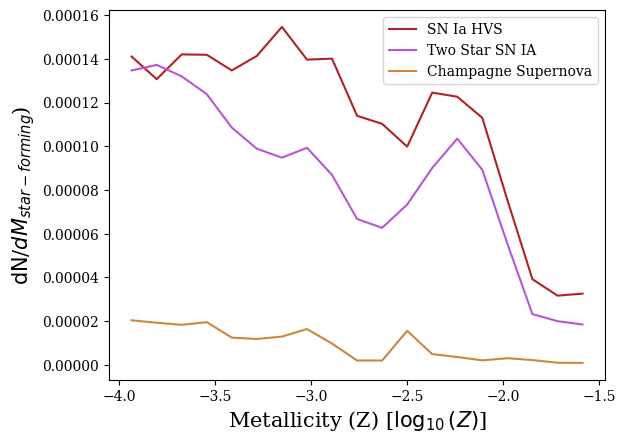

In [44]:
# let's plot our counts vs metallicities!

plt.plot(center_bin_z, formation_efficency_SN_Ia_HVS, color='firebrick', label='SN Ia HVS')
plt.plot(center_bin_z, formation_efficency_two_star_SNIA, color='mediumorchid', label='Two Star SN IA')
plt.plot(center_bin_z, formation_efficency_Champagne_Supernova, color='peru', label='Champagne Supernova')
plt.xlabel(r"Metallicity (Z) [$\log_{10}(Z)$]", fontsize=15)
plt.ylabel(r"$\mathrm{dN}$/$dM_{star-forming}$)",fontsize=15)

plt.legend()

Both methods get me the same plot and values! We are just missing one system in each method

Let's do this again for neutron star - neutron star systems

In [31]:
# reading in the HDF5 file
pathTorates_NS = '/home/jovyan/CompasOutput/v02.46.01/N1e6_Fid_NSNS_AIS/CosmicIntegration/Rate_info.h5' #path of the hdf5 file

Data_rates_NS = h5.File(pathTorates_NS)

In [32]:
list(Data_rates_NS['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'].keys())
rates_info_NS = Data_rates_NS['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned']
rates_info_NS.keys()

<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>

In [33]:
dco_mask_NS = rates_info_NS['DCOmask'][()]

In [34]:
# reading in the HDF5 file
pathToweights_NS = '/home/jovyan/CompasOutput/v02.46.01/N1e6_Fid_NSNS_AIS/MainRun/COMPAS_Output_wWeights.h5' #path of the hdf5 file

Data_weights_NS = h5.File(pathToweights_NS)

In [35]:
# we want to read in the bse_RLOF to get information about thes different systems

DCO_NS_data = pd.DataFrame() # making a pandas dataframe

for key in Data_weights_NS["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

    DCO_NS_data[key] = Data_weights_NS["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

In [36]:
merging_all_NS = DCO_NS_data[dco_mask_NS]
merging_all_NS

,CE_Event_Counter,Coalescence_Time,Eccentricity@DCO,Immediate_RLOF>CE,MT_Donor_Hist(1),MT_Donor_Hist(2),Mass(1),Mass(2),Merges_Hubble_Time,Metallicity@ZAMS(1),...,SEED,SemiMajorAxis@DCO,Stellar_Type(1),Stellar_Type(2),Time,dmMT(1),dmMT(2),dmWinds(1),dmWinds(2),mixture_weight
323,1,4.914255,0.144223,0,b'2 ',b'4-8 ',1.210342,1.442315,1,0.000686,...,7235,0.002952,13,13,38.082441,0.000099,-1.448854,0.0,0.0,0.024294
1336,1,110.465241,0.730318,0,b'2 ',b'4-8 ',1.260087,1.424028,1,0.000537,...,29725,0.012377,13,13,39.974896,0.000087,-1.417040,0.0,0.0,0.028337
1759,1,3594.070404,0.356025,0,b'5 ',b'8 ',1.480496,1.171439,1,0.025743,...,39167,0.016939,13,13,24.544319,0.000072,-1.093873,0.0,0.0,0.011341
1915,1,15.038578,0.292517,0,b'4-8 ',b'8 ',1.188053,1.203831,1,0.001179,...,42602,0.003843,13,13,38.306424,0.000179,-1.376143,0.0,0.0,0.025722
1955,1,6.854551,0.692189,0,b'2 ',b'4-8 ',1.260033,1.195963,1,0.013255,...,43466,0.005260,13,13,36.808308,0.000033,-1.205352,0.0,0.0,0.023426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46667,1,2.035270,0.304401,0,b'2 ',b'4-8 ',1.242316,1.573235,1,0.002852,...,999727,0.002643,13,13,35.825917,0.000153,-1.611445,0.0,0.0,0.013998
46668,1,0.978486,0.008180,0,b'2 ',b'4-8 ',1.260145,1.554736,1,0.000184,...,999770,0.002022,13,13,36.031843,0.000145,-1.593994,0.0,0.0,0.025480
46671,1,2.060512,0.283681,0,b'2 ',b'4-8 ',1.260112,1.308423,1,0.000471,...,999894,0.002454,13,13,40.501417,0.000112,-1.432607,0.0,0.0,0.007313
46672,1,0.808230,0.271005,0,b'2 ',b'4-8 ',1.260144,1.752863,1,0.000146,...,999931,0.002160,13,13,36.358539,0.000144,-1.707163,0.0,0.0,0.017477


In [37]:
# let's first make our bins that we want that are evenly spaced in log
metallicities_NSNS = np.array(merging_all_NS['Metallicity@ZAMS(1)'])
metallicities_log_NSNS = np.log10(metallicities)
even_Z_NSNS = np.linspace(-4, np.max(metallicities_log_NSNS), 20)
bins_Z_NSNS = even_Z_NSNS
bins_Z_NSNS

array([-4.        , -3.8696316 , -3.73926319, -3.60889479, -3.47852639,
       -3.34815799, -3.21778958, -3.08742118, -2.95705278, -2.82668438,
       -2.69631597, -2.56594757, -2.43557917, -2.30521077, -2.17484236,
       -2.04447396, -1.91410556, -1.78373716, -1.65336875, -1.52300035])

We now want to count how many systems are in each of these metallicity bins

In [38]:
# Get the total mass evolved per Z
# think about hoe bonary fraction changes fro different mass bins (Offner, Moe 2022) - figure 1
totalMassEvolvedPerMetallicity_NS = totalMassEvolvedPerZ(pathToweights_NS,
                         binaryFraction=0.7, Mmin_universe=0.05, Mmax_universe=300.,
                         metallicity_bins = 10**(bins_Z_NSNS))
print('Total mass evolved per Z:', totalMassEvolvedPerMetallicity_NS)

Weighted samples
using continuous metallicities !! Assumed to be sampled flat-in-log !!
Total mass evolved per Z: [0.00000000e+00 1.09749063e+06 1.10153586e+06 1.10046809e+06
 1.09455424e+06 1.08843505e+06 1.08457463e+06 1.09882535e+06
 1.08935909e+06 1.07929734e+06 1.09566309e+06 1.08395860e+06
 1.07615561e+06 1.07139168e+06 1.06543676e+06 1.07287014e+06
 1.06071390e+06 1.06948200e+06 1.05457418e+06 1.04870140e+06
 6.98162317e+02]


In [39]:
len(totalMassEvolvedPerMetallicity_NS)

21

In [40]:
bin_indices_NS = np.digitize(np.log10(merging_all_NS['Metallicity@ZAMS(1)']), bins_Z_NSNS) # Bin your metallicities, make sure both bins in log space
# np.digitize - checks which metallicity bin a specific compas metals should fall in (with say which numbered bin the system should be in)
# return an array of numbers that represent the bins (the 1st metallicity is in bin 5...)
print(len(np.unique(bin_indices_NS)))

19


In [41]:
# weights = np.array(merging_all_NS['mixture_weight']) # let's gather the micture weights we have for these systems
weighted_counts_NS = [] # let's make an empty list to add to later

# we can loop through our first to 20th metallicity bin
for bin in np.unique(bin_indices_NS):
    metals_bool = np.where(bin_indices_NS==bin)[0] # we want to see where in our array a system falls within to a certain bin
    # for example we want to see where in bin_indicies the systems fall into the first metallicity bin 
    weighted_counts_NS.append(sum(merging_all_NS['mixture_weight'].iloc[metals_bool])) # we then select only the weights pertaining to a certian metallicity bin and sum them up

In [42]:
# divide the weighted sums with the total mass evolved oer metallicity

formation_efficency_NS = weighted_counts_NS/totalMassEvolvedPerMetallicity_NS[1:]
# number of systems formed / mass evolved for these systems to be made (take the nondiscrete and weighted samples metallicity)

ValueError: operands could not be broadcast together with shapes (19,) (20,) 

Text(0, 0.5, 'Number of NSNS Systems')

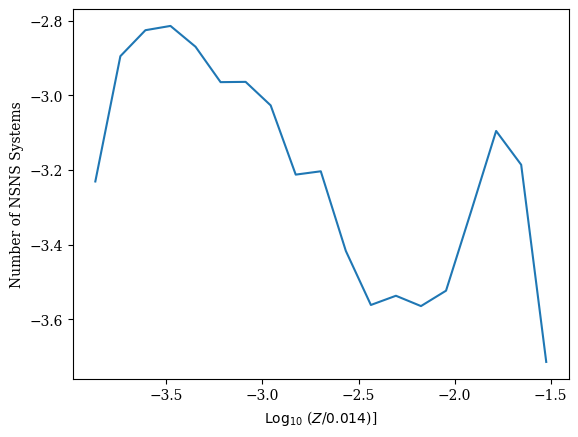

In [ ]:
# need to take one less bin in the bins_Z array because the last bin is just anything greater than a certain metallicity
plt.plot(bins_Z_NSNS[1:20], np.log10(counts_bins_NSNS_array/totalMassEvolvedPerMetallicity[1:20])) # this does not seem correct 
plt.xlabel(r"$\mathrm{Log_{10}}$ ($Z$/$\mathrm{0.014}$)]")
plt.ylabel(r"Number of NSNS Systems")

Let's try the histogram route

Text(0, 0.5, 'dN/$dM_{2}$ [$Log_{10} Scale$]')

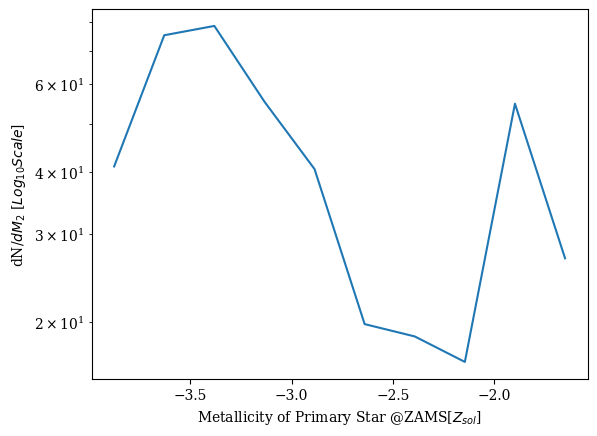

In [ ]:
# let's make a histogram of the masses of these NBS with the weights of this histogram being the merger rates (to get the mass distrubition curvw), change what pass you are plotting

# below makes it so if i change the number of bins or anything like that it will not change th eshaoe if the distribution
hist, bin_edges = np.histogram(np.log10(merging_all_NS['Metallicity@ZAMS(1)']), weights=merging_all_NS['mixture_weight'])
center_bins = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

plt.plot(center_bins,(hist/bin_width))
# plt.step(center_bins,hist/bin_width,where='mid')

plt.xlabel(r"Metallicity of Primary Star @ZAMS[$Z_{sol}$]")
plt.yscale('log')
# plt.ylim(1e-1,1e3)
plt.ylabel(r"dN/$dM_{2}$ [$Log_{10} Scale$]")
# plt.title("Mass Distribution of the Primary Star")\



In [43]:
# i think I also need to find the anount of mass caused to form a NSNS merger oer metallicity
# do this for the neutron star simulation and divide by total mass evloved per metallicity and see if comparable to what Lieke sent
# because using AIS, we need to sum the weights of each system to count whihc systems go to which bins accuratley - if I used np.histogram (use the flag weights)
# or use what I did before but instead of counting each system, 

Let's try to normalize this with the average star forming mass needed for each metallicity